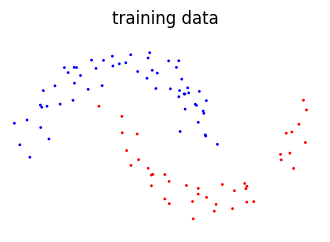

ELBO loss: 149010473.75: 100%|██████████| 1000/1000 [00:24<00:00, 41.16it/s]


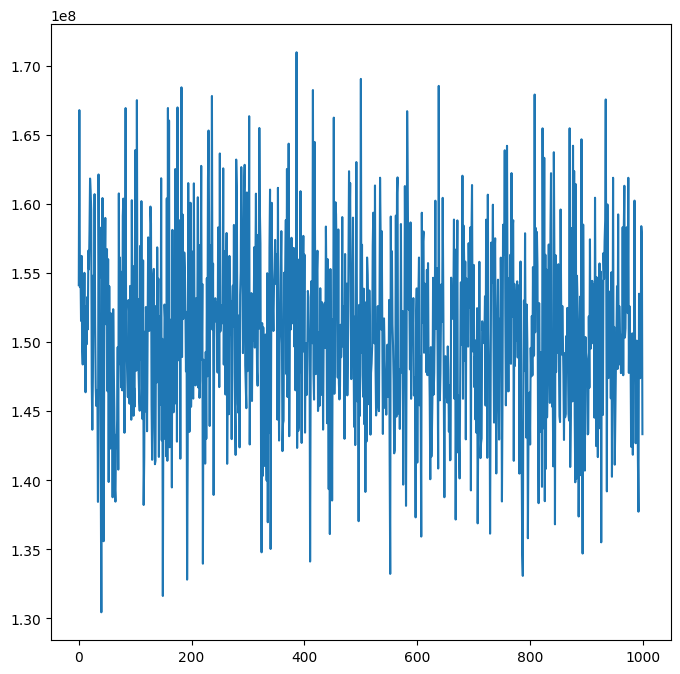

In [13]:
"""Implement CalVI training for the two moons toy problem."""

import os

import matplotlib
import matplotlib.pyplot as plt
import pyro
import torch
import zuko
from click import command, option
import functools

import wandb
from scripts.training import train
from scripts.two_moons_wzy.model import *
from scripts.utils import kl_divergence, ConditionalGaussianMixture

from pyro.infer.autoguide import AutoIAFNormal
import pyro
from tqdm import tqdm


seed = 0
n_steps = 1000
lr = 1e-3
lr_gamma = 1.0
lr_steps = 1000
grad_clip = 100


"""Generate data and train the SWI model."""
# matplotlib.use("Agg")
# matplotlib.rcParams["figure.dpi"] = 300

# Generate data (use consistent seed for all runs to make data)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
pyro.set_rng_seed(0)

# Generate training data
# TODO: this

# Change seed for training
torch.manual_seed(seed)
pyro.set_rng_seed(seed)

def plot_things(samples, labels, title=None):
    plt.figure(figsize=(4, 4))
    plt.scatter(*samples.T, s=1, c=labels, cmap="bwr")
    # Turn off axis ticks
    plt.xticks([])
    plt.yticks([])
    plt.axis("off")
    plt.ylim([-1.1, 1.1])
    plt.xlim([-1.7, 1.7])
    if title is not None:
        plt.title(title)
    # Equal aspect
    plt.gca().set_aspect("equal")
    plt.show()

n_days = 100

y_obs, w_obs = generate_two_moons_data_hierarchical(n_days, device)
plot_things(y_obs, w_obs > .5, "training data")

w_z_y_model = functools.partial(
    two_moons_w_z_y_model,
    n=n_days,
    device=device,
)

w_z_y_guide = AutoIAFNormal(w_z_y_model)

# # TODO: figure out how to specify a custom loss
# def simple_elbo(model, guide, *args, **kwargs):
#     # run the guide and trace its execution
#     guide_trace = pyro.poutine.trace(guide).get_trace(*args, **kwargs)
#     # run the model and replay it against the samples from the guide
#     model_trace = pyro.poutine.trace(
#         pyro.poutine.replay(model, trace=guide_trace)).get_trace(*args, **kwargs)
#     # construct the elbo loss function
#     return -1*(model_trace.log_prob_sum() - guide_trace.log_prob_sum())

# l = simple_elbo(w_z_y_model, w_z_y_guide, w_obs=w_obs, y_obs=y_obs)
# # print(l)

# Train the model
# set up the optimizer
n_steps = n_steps
gamma = 0.1  # final learning rate will be gamma * initial_lr
lrd = gamma ** (1 / n_steps)
optim = pyro.optim.ClippedAdam({"lr": lr, "lrd": lrd})
elbo = pyro.infer.Trace_ELBO(num_particles=5)

# setup the inference algorithm
svi = pyro.infer.SVI(
    w_z_y_model, 
    w_z_y_guide, 
    optim, 
    loss=elbo,
)

# do gradient steps
pbar = tqdm(range(n_steps))
losses = []
for step in pbar:
    loss = svi.step(w_obs=w_obs, y_obs=y_obs)
    losses.append(loss)
    if step % 10 == 0:
        pbar.set_description(f"ELBO loss: {loss:.2f}")

plt.figure(figsize=(8,8))
plt.plot(losses)
plt.show()

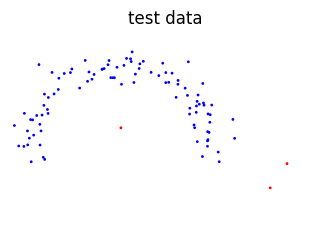

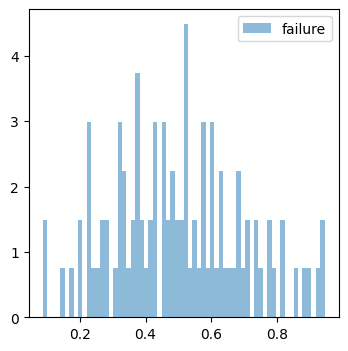

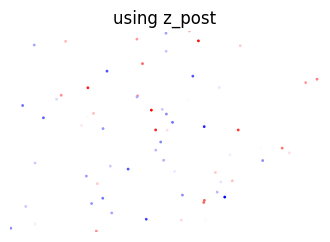

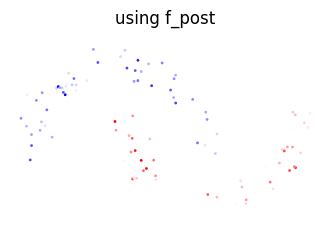

In [14]:
y_obs, w_obs = generate_two_moons_data_hierarchical(n_days, device, nominal=True)
plot_things(y_obs, w_obs > .5, "test data")
# print(w_obs)

# predictive = pyro.infer.Predictive(
#     w_z_y_model, 
#     guide=w_z_y_guide, 
#     num_samples=100,
# )
# with pyro.plate("samples", n_samples, dim=-1):
#     posterior_samples = auto_guide(states, dt)
with pyro.plate("samples", 1, dim=-2):
    samples = w_z_y_guide(w_obs=w_obs, y_obs=y_obs)

# print(samples)

# w_post = samples['w'].flatten()
# z_post = samples['z'].reshape(-1, 2)
# t_post = samples['theta'].flatten()
# f_post = samples['failure'].flatten()
# w_post = samples['w'].mean(dim=0)
z_post = samples['z'].mean(dim=0).detach()
t_post = samples['theta'].mean(dim=0).detach()
f_post = samples['failure'].mean(dim=0).detach()

# print(w_post)

plt.figure(figsize=(4, 4))
plt.hist(f_post, density=True, bins=64, label='failure',alpha=.5)
# plt.hist(t_post, density=True, bins=32, label='theta',alpha=.5)
# plt.hist(w_post, density=True, bins=64, label='w', alpha=.5)
plt.legend()
plt.show()

y_obs, w_obs = generate_two_moons_data_hierarchical(n_days, device, z_obs=z_post)
plot_things(y_obs, f_post, 'using z_post')

y_obs, w_obs = generate_two_moons_data_hierarchical(n_days, device, failure_obs=f_post)
plot_things(y_obs, f_post, 'using f_post')
